In [32]:
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [33]:
# matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [34]:
# 1 get data from SDK
def getCoviddata():
    # this is filter that include area of england
    england_only = [
        'areaType=nation',
        'areaName=England'
    ]

    # dataFromNewCase CumulativeTest HospitalCase ventilatorBed NewAdmission
    cases_and_deaths = {
        "date": "date",
        "newCasesByPublishDate": "newCasesByPublishDate",
        "cumCasesByPublishDate": "cumCasesByPublishDate",
        "cumTestsByPublishDate": "cumTestsByPublishDate",
        "hospitalCases": "hospitalCases",
        "newAdmissions": "newAdmissions",
        "covidOccupiedMVBeds": "covidOccupiedMVBeds"
    }

    api = Cov19API(filters=england_only, structure=cases_and_deaths)

    # change to json
    getData = api.get_json()

    #write data in json
    OUTFILE = open("getData.json", "wt")
    json.dump(getData, OUTFILE)
    OUTFILE.close()

    #read data in json
    INFILE = open("getData.json", "rt")
    jsonData = json.load(INFILE)
    INFILE.close()

    return jsonData

<AxesSubplot:>

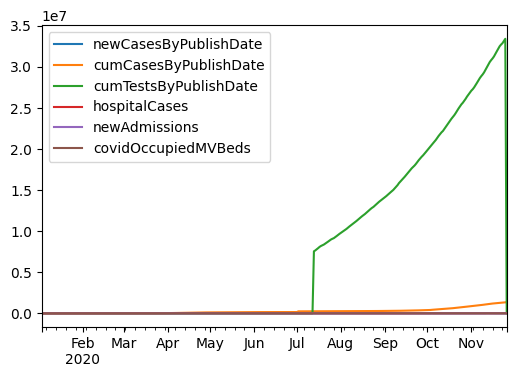

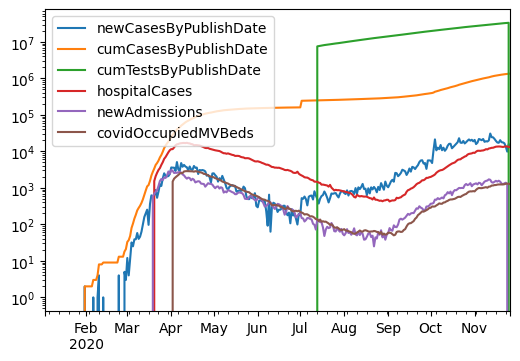

In [37]:
# 2 Wrangling the Data
# split and order the date   
def wrangle_data(data):  
    datalist=data['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()

    # parse data base on pandas
    def parse_date(datestring):
        """ Convert a date string into a pandas datetime object """
        return pd.to_datetime(datestring, format="%Y-%m-%d")

    # time period
    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])

    # 3 plot the graph
    #dataFrame
    index=pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['newCasesByPublishDate', 
                                                    'cumCasesByPublishDate', 
                                                    'cumTestsByPublishDate',
                                                    'hospitalCases',
                                                    'newAdmissions',
                                                    'covidOccupiedMVBeds'])

    for entry in datalist: # each entry is a dictionary with newCasesByPublishDate', 'cumCasesByPublishDate', 'cumTestsByPublishDate','hospitalCases','newAdmissions','covidOccupiedMVBeds
        date=parse_date(entry['date'])
        for column in ['newCasesByPublishDate', 'cumCasesByPublishDate', 'cumTestsByPublishDate','hospitalCases','newAdmissions','covidOccupiedMVBeds']:
            # check that nothing is there yet - just in case some dates are duplicated,
            # maybe with data for different columns in each entry
            if pd.isna(timeseriesdf.loc[date, column]): 
                # replace None with 0 in our data 
                value= float(entry[column]) if entry[column]!=None else 0.0
                # this is the way you access a specific location in the dataframe - use .loc
                # and put index,column in a single set of [ ]
                timeseriesdf.loc[date, column]=value
                
    # fill in any remaining "holes" due to missing dates
    timeseriesdf.fillna(0.0, inplace=True)
    # plot the graph
    # timeseriesdf.plot()
    # timeseriesdf.plot(logy=True)
    #save data in pickle file
    timeseriesdf.to_pickle("visualisingTheData.pkl")

    return timeseriesdf

df = wrangle_data(getCoviddata())
df.plot()
df.plot(logy=True)

In [35]:
##Interactive Graph

In [38]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    # this is filter that include area of england
    england_only = [
        'areaType=nation',
        'areaName=England'
    ]

    # dataFromNewCase CumulativeTest HospitalCase ventilatorBed NewAdmission
    cases_and_deaths = {
        "date": "date",
        "newCasesByPublishDate": "newCasesByPublishDate",
        "cumCasesByPublishDate": "cumCasesByPublishDate",
        "cumTestsByPublishDate": "cumTestsByPublishDate",
        "hospitalCases": "hospitalCases",
        "newAdmissions": "newAdmissions",
        "covidOccupiedMVBeds": "covidOccupiedMVBeds"
    }

    api = Cov19API(filters=england_only, structure=cases_and_deaths)

    # change to json
    getData = api.get_json()

    #write data in json
    OUTFILE = open("getData.json", "wt")
    json.dump(getData, OUTFILE)
    OUTFILE.close()

    #read data in json
    INFILE = open("getData.json", "rt")
    jsonData = json.load(INFILE)
    INFILE.close()

    return jsonData

In [39]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # you can omit this step in the first instance
    # refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. You can use icons
    # "unlink" or "times" and change the button text to "Unavailable" in case the 
    # api call fails.
    apibutton.icon="check"
    apibutton.disabled=True

apibutton=wdg.Button(
    description='Refresh data', # you may want to change this...
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="click to update",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='download'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

#display(apibutton)

# run all cells before clicking on this button

In [40]:
# Interactive Graph
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("visualisingTheData.pkl")

series=wdg.SelectMultiple(
    options=['newCasesByPublishDate', 'cumCasesByPublishDate', 'cumTestsByPublishDate', 'hospitalCases', 'newAdmissions', 'covidOccupiedMVBeds'],
    value=['newCasesByPublishDate', 'cumCasesByPublishDate', 'cumTestsByPublishDate', 'hospitalCases', 'newAdmissions', 'covidOccupiedMVBeds'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); capture output in variable graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

# stack series and scale on top of each other
ctrls=wdg.VBox([series, scale])
# put the graph and the controls side by side
form=wdg.HBox([graph, ctrls])

# Now form contains the entire interface
display(form)
display(apibutton)


Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='click to update')